## Model 1

This first model consists of a simple 3D autoencoder with 2 conv3D and 2 conv3DTranspose. Compression ratio is (2^3)^2 = 64 divided across 20 filters, that would make: 64/20 = 3.2 = CP. It's a low ratio.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from collections import OrderedDict
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data
from lossycomp.utils import decay_schedule, r2_coef
from lossycomp.plots import plot_loss, plot_r2, single_plot, mult_plot

In [2]:
model = models.Sequential()
model.add(layers.Conv3D(10, (4, 4, 4), activation='relu', strides=2, input_shape=(12, 40, 40, 1), padding="same", data_format = "channels_last"))
model.add(layers.Conv3D(20, (4, 4, 4), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(10, (4, 4, 4), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(1, (4, 4, 4), strides=2, padding="same", activation = None))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 6, 20, 20, 10)     650       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 10, 10, 20)     12820     
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 6, 20, 20, 10)     12810     
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 12, 40, 40, 1)     641       
Total params: 26,921
Trainable params: 26,921
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef])

In [5]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean, std = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 12, longitude=40, latitude=40, level=1)

dg_train = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 
dg_test = DataGenerator(test, 20000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM
Loading data into RAM


In [6]:
lr_scheduler = LearningRateScheduler(decay_schedule)

In [7]:
history = model.fit(dg_train, validation_data = dg_test, epochs=25, callbacks=[lr_scheduler])

Epoch 1/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0579 - r2_coef: 0.9649 - val_loss: 0.0175 - val_r2_coef: 0.9897
Epoch 2/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0066 - r2_coef: 0.9960 - val_loss: 0.0125 - val_r2_coef: 0.9924
Epoch 3/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0044 - r2_coef: 0.9973 - val_loss: 0.0090 - val_r2_coef: 0.9945
Epoch 4/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0032 - r2_coef: 0.9981 - val_loss: 0.0067 - val_r2_coef: 0.9959
Epoch 5/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0029 - r2_coef: 0.9983 - val_loss: 0.0057 - val_r2_coef: 0.9966
Epoch 6/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0022 - r2_coef: 0.9986 - val_loss: 0.0046 - val_r2_coef: 0.9972
Epoch 7/25
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0023 - r2_coef: 0.9986 - val_loss: 0.0042 - val_r2_coef:

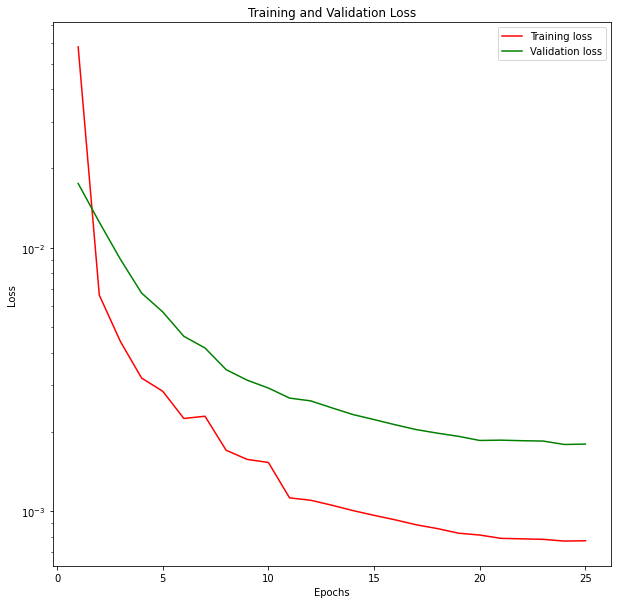

In [8]:
plot_loss(history, 'Training and Validation Loss', 'Epochs', 'Loss')

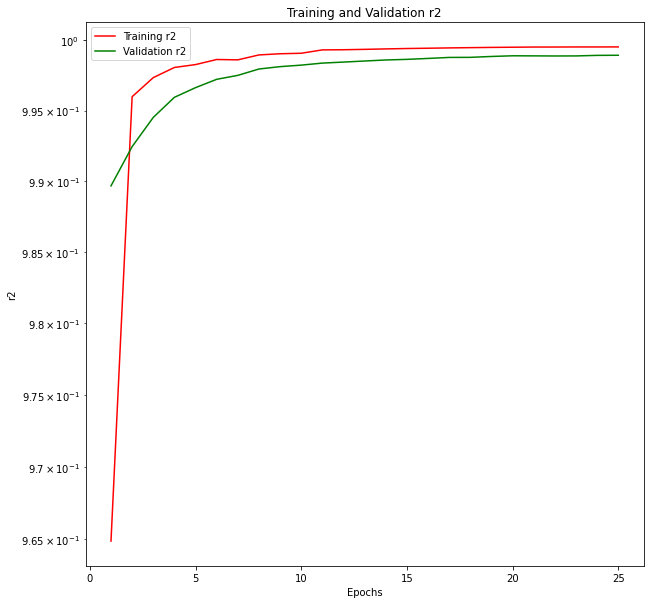

In [10]:
plot_r2(history, 'Training and Validation r2', 'Epochs', 'r2')

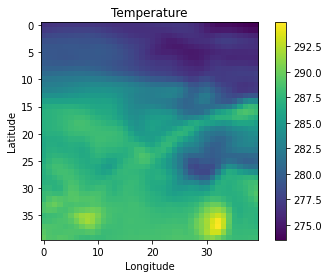

In [13]:
a = dg_train.__getitem__(2)[0] 
a_n = norm_data(a, mean, std)
single_plot(a_n, 10, "Temperature")

In [14]:
result = model(np.expand_dims(a[0], axis=0)).numpy()

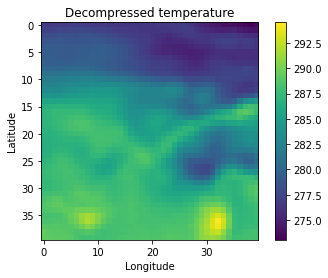

In [15]:
result = norm_data(result, mean, std)
single_plot(result, 10, "Decompressed temperature" )

In [16]:
test = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1979-11-14T16:00:00','1979-11-15T03:00:00'),level = slice(978,1000), longitude=slice(6,15.75), latitude=slice(55.5,45.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 12, 40, 40, 1)

## Results

Original:

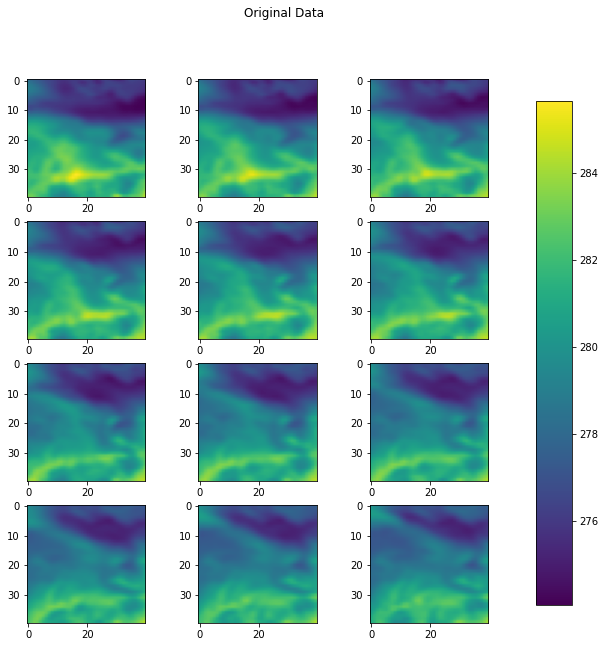

In [17]:
test_n = norm_data(test_data, mean, std)
mult_plot(test_n, 4, 3, "Original Data", test_n.min(), test_n.max())

Decompressed:

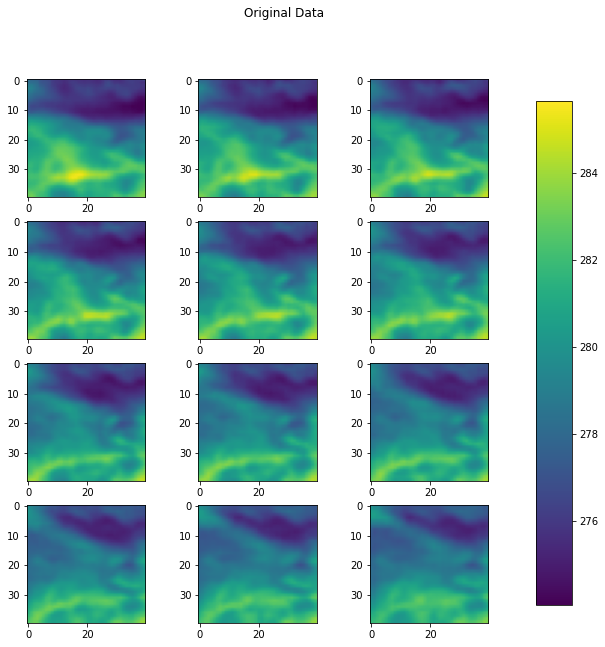

In [18]:
result2 = model(test_data).numpy()
result2 = norm_data(result2, mean, std)

mult_plot(result2, 4, 3, "Original Data", test_n.min(), test_n.max())

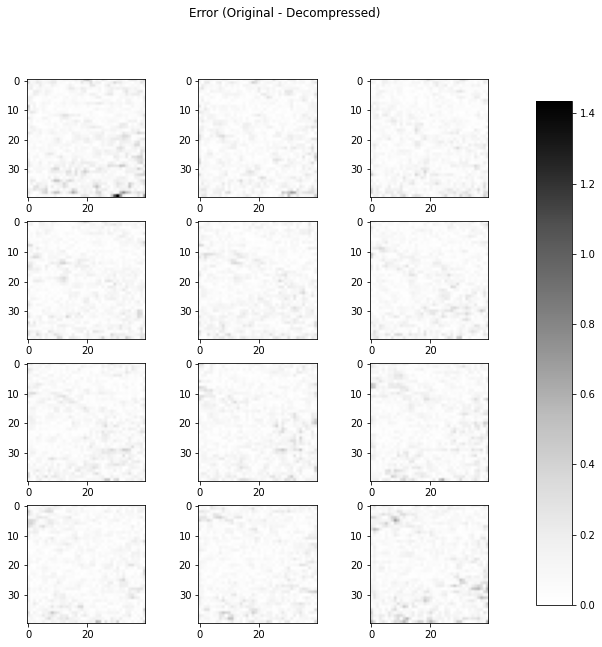

In [19]:
result3 = np.absolute(test_n-result2)
mult_plot(result3, 4, 3, "Error (Original - Decompressed)", result3.min(), result3.max(), 'Greys')